In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import timeit

In [6]:
from src.ensembles import *

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [17]:
data = pd.read_csv('kc_house_data.csv')

In [18]:
data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,...,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


In [6]:
data.isna().sum().sum()

0

In [7]:
data.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

In [20]:
target = data['price'].values
data = data.drop(['price', 'id', 'date'], axis=1)

In [22]:
X = data.values
X.shape

(21613, 18)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=10)

In [11]:
X_train.shape, X_test.shape

((17290, 18), (4323, 18))

## Random Forest

In [54]:
%%time
clf = RandomForestMSE(n_estimators = 700)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Wall time: 1min 21s


In [55]:
print(f'RandomForest RMSE: {rmse(y_test, y_pred)}')

RandomForest RMSE: 151416.0398375707


Проанализируем работу RandomForest. Подберём для него гиперпараметры.

In [11]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=10)

In [12]:
X_tr.shape, X_val.shape

((13832, 18), (3458, 18))

In [14]:
def rmse(y, pred):
    return np.sqrt(((y - pred)**2).mean())

In [14]:
def plot_rmse(rmse_train, rmse_val, x, title, xlabel):
    plt.figure(figsize=(7, 4))
    plt.plot(x, rmse_train, marker='.', label='train')
    plt.plot(x, rmse_val, marker='.', label='val')

    plt.title(title, fontsize=14)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel('RMSE', fontsize=14)
    plt.legend()
    plt.grid(True)

In [15]:
def plot_time(time, x, title, xlabel):
    plt.figure(figsize=(7, 4))
    plt.plot(x, time, marker='.', label='train')

    plt.title(title, fontsize=14)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel('Time, sec', fontsize=14)
    plt.legend()
    plt.grid(True)

In [16]:
def num_estimators(regressor, X_train, y_train, X_val, y_val, n_trees):
    rmse_train = []
    rmse_val = []
    time = []

    for n in n_trees:
        start_time = timeit.default_timer()
        clf = regressor(n_estimators=n)
        clf.fit(X_train, y_train)

        q_train = rmse(y_train, clf.predict(X_train))
        q_test = rmse(y_val, clf.predict(X_val))
        rmse_train.append(q_train)
        rmse_val.append(q_test)

        time.append(timeit.default_timer() - start_time)
    return rmse_train, rmse_val, time

Для начала подберём количество деревьев в лесе. При этом остальные параметры оставим по дефолту ($max\_depth = None, feature\_size = X.shape[1] // 3$)

In [38]:
n_trees = [1, 5, 10, 100, 200, 300, 400, 500, 700, 1000, 2000]
rmse_train, rmse_test, time = num_estimators(RandomForestMSE, X_tr, y_tr, X_val, y_val, n_trees)

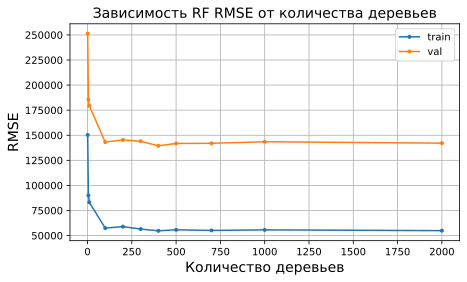

In [39]:
title = 'Зависимость RF RMSE от количества деревьев'
xlabel = 'Количество деревьев'
plot_rmse(rmse_train, rmse_test, n_trees, title, xlabel)
plt.savefig('forest_numtree_rmse.pdf')

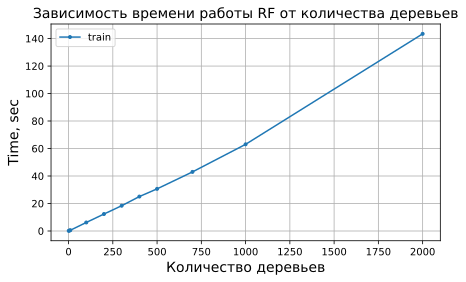

In [40]:
title = 'Зависимость времени работы RF от количества деревьев'
plot_time(time, n_trees, title, xlabel)
plt.savefig('forest_numtree_time.pdf')

Видим что, при малом количестве деревьев модель плохо обучается. С ростом их числа ошибка уменьшилась больше чем в 2 раза. Но после 200 RMSE выходит на плато и перестаёт уменьшаться. Также заметим, что время работы алгоритма растёт линейно с увеличением количества деревьев в лесе. На практике известно, что 200 может не хватить для обучения, поэтому всюду дальше будем брать чуть больше деревьев - 700. 

Теперь исследуем качество работы метода в зависимости от глубины дерева.

In [17]:
def max_depth(regressor, X_train, y_train, X_val, y_val, n_trees, depth):
    rmse_train = []
    rmse_val = []
    time = []
    
    for d in depth:
        start_time = timeit.default_timer()
        clf = regressor(n_estimators=n_trees, max_depth = d)
        clf.fit(X_train, y_train)

        q_train = rmse(y_train, clf.predict(X_train))
        q_test = rmse(y_val, clf.predict(X_val))
        rmse_train.append(q_train)
        rmse_val.append(q_test)

        time.append(timeit.default_timer() - start_time)
    return rmse_train, rmse_val, time

In [46]:
depth = list(range(1, 20, 2))
rmse_train, rmse_test, time = max_depth(RandomForestMSE, X_tr, y_tr, X_val, y_val, 700, depth)

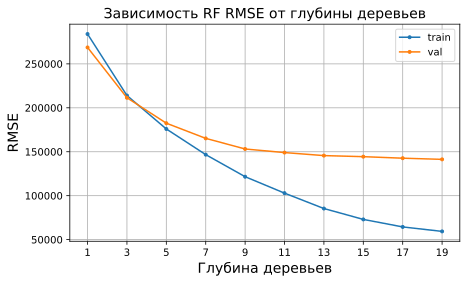

In [47]:
title = 'Зависимость RF RMSE от глубины деревьев'
xlabel = 'Глубина деревьев'
plot_rmse(rmse_train, rmse_test, depth, title, xlabel)
plt.xticks(depth)
plt.savefig('forest_depth_rmse.pdf')

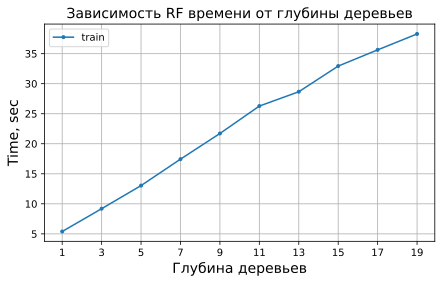

In [48]:
title = 'Зависимость RF времени от глубины деревьев'
plot_time(time, depth, title, xlabel)
plt.xticks(depth)
plt.savefig('forest_depth_time.pdf')

Видим, что при малой глубине дерева модель довольно плохо обучается. Качество на валидации перестаёт меняться примерно с 15. Такую глубину мы дальше и будем использовать. Заметим, что так же с ростом глубины, лесу свойственно переобучаться под обучающую выборку. Время зависимости от глубины так же линейно.

Проверим, как влияет на ошибку размерность признакового пространства для одного дерева

In [18]:
def feature_size(regressor, X_train, y_train, X_val, y_val, n_trees, max_depth, feat_size):
    rmse_train = []
    rmse_val = []
    time = []
    
    for size in feat_size:
        start_time = timeit.default_timer()
        clf = regressor(n_estimators=n_trees, max_depth = max_depth,
                              feature_subsample_size = size)
        clf.fit(X_train, y_train)

        q_train = rmse(y_train, clf.predict(X_train))
        q_test = rmse(y_val, clf.predict(X_val))
        rmse_train.append(q_train)
        rmse_val.append(q_test)

        time.append(timeit.default_timer() - start_time)
    return rmse_train, rmse_val, time

In [58]:
feat_size = list(range(1, X_tr.shape[1], 2))
rmse_train, rmse_test, time = feature_size(RandomForestMSE, X_tr, y_tr, X_val, y_val, 700, 15, feat_size)

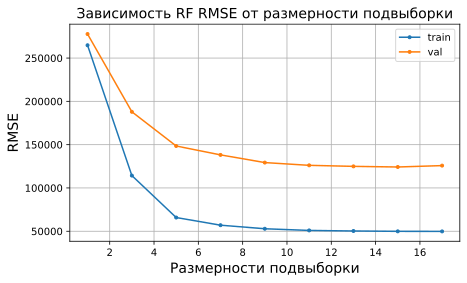

In [164]:
title = 'Зависимость RF RMSE от размерности подвыборки'
xlabel = 'Размерности подвыборки'
plot_rmse(rmse_train, rmse_test, feat_size, title, xlabel)
plt.savefig('forest_size_rmse.pdf')

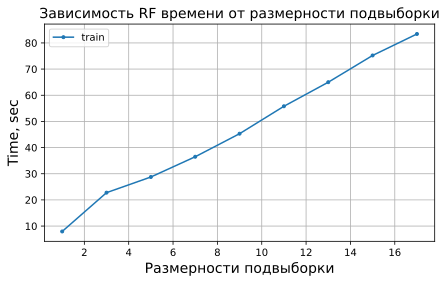

In [59]:
title = 'Зависимость RF времени от размерности подвыборки'
xlabel = 'Размерности подвыборки'
plot_time(time, feat_size, title, xlabel)
plt.savefig('forest_size_time.pdf')

Здесь можно сделать аналогичные выводы, что и в предыдущих пунктах. При малом количестве признакового пространства, модель плохо улавливает зависимости. А при слишком большом довольно сильно переобучается. Время зависимости так же практически линейно. Дальше будем использовать 11 признаков.

Мы подобрали гиперпараметры по валидации. Теперь обучим модель на всей выборке и посмотрим на качество работы алгоритма на тесте. Возьмём $n\_estimators=700, max\_depth = 15, feature\_subsample\_size = 11$.

In [53]:
%%time
clf = RandomForestMSE(n_estimators=700, max_depth = 15,
                              feature_subsample_size = 11)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Wall time: 1min 45s


In [159]:
print(f'RandomForest RMSE: {rmse(y_test, y_pred)}')

RandomForest RMSE: 133643.75117143017


## Gradient Boosting

In [37]:
%%time
clf = GradientBoostingMSE(n_estimators=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Wall time: 25 s


In [38]:
print(f'GradientBoosting RMSE: {rmse(y_test, y_pred)}')

GradientBoosting RMSE: 144862.19401370402


Теперь аналогичным образом подберём параметры для модели градиентного бустинга.

Точно так же сначала подберём количество деревьев. При этом остальные параметры оставим по дефолту ($max\_depth = 5, feature\_size = X.shape[1] // 3, learning\_rate = 0.1$)

In [127]:
n_trees = [1, 5, 10, 100, 200, 300, 400, 500, 700, 1000, 2000]
rmse_train, rmse_test, time = num_estimators(GradientBoostingMSE, X_tr, y_tr, X_val, y_val, n_trees)

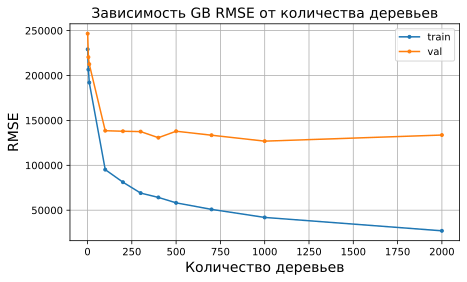

In [128]:
title = 'Зависимость GB RMSE от количества деревьев'
xlabel = 'Количество деревьев'
plot_rmse(rmse_train, rmse_test, n_trees, title, xlabel)
plt.savefig('gb_numtree_rmse.pdf')

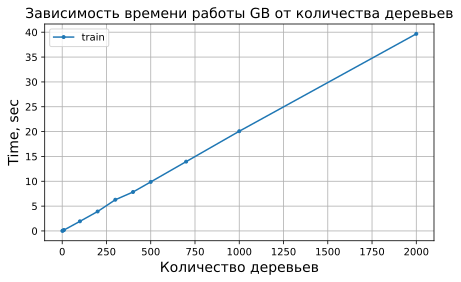

In [129]:
title = 'Зависимость времени работы GB от количества деревьев'
plot_time(time, n_trees, title, xlabel)
plt.savefig('gb_numtree_time.pdf')

Тут можно сделать аналогичные выводы, что и для алгоритма RandomForest. Наилучшим значением на валидации стало 1000 деревьев. Столько мы дальше и будем использовать.

Подберём теперь глубину деревьев.

In [144]:
depth = list(range(1, 18, 2))
rmse_train, rmse_test, time = max_depth(GradientBoostingMSE, X_tr, y_tr, X_val, y_val, 1000, depth)

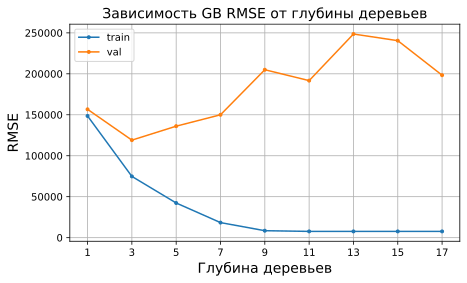

In [149]:
title = 'Зависимость GB RMSE от глубины деревьев'
xlabel = 'Глубина деревьев'
plot_rmse(rmse_train, rmse_test, depth, title, xlabel)
plt.xticks(depth)
plt.savefig('gb_depth_rmse.pdf')

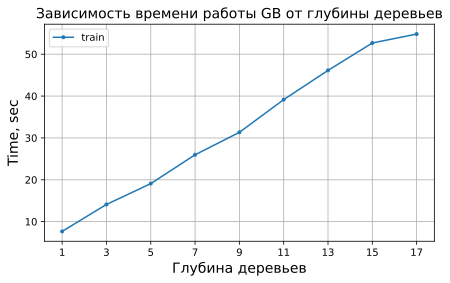

In [148]:
title = 'Зависимость времени работы GB от глубины деревьев'
plot_time(time, depth, title, xlabel)
plt.xticks(depth)
plt.savefig('gb_depth_time.pdf')

Видим, что в случае с градиентным бустингом ситуация немного другая, чем с лесом. С ростом глубины деревьев ошибка на обучачющей выборке падает, но на валидационной возрастает. Отметим, что наилучшим значением этого параметра является 3. Его мы дальше и будем использовать. Заметим так же, что зависимость времени работы модели от глубины линейно.

Исследуем теперь зависимость качества от признакого пространства.

In [29]:
feat_size = list(range(1, X_tr.shape[1], 2))
rmse_train, rmse_test, time = feature_size(GradientBoostingMSE, X_tr, y_tr, X_val, y_val, 1000, 3, feat_size)

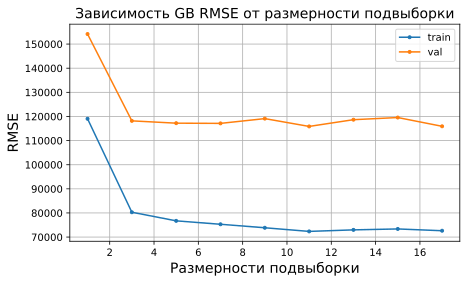

In [30]:
title = 'Зависимость GB RMSE от размерности подвыборки'
xlabel = 'Размерности подвыборки'
plot_rmse(rmse_train, rmse_test, feat_size, title, xlabel)
plt.savefig('gb_size_rmse.pdf')

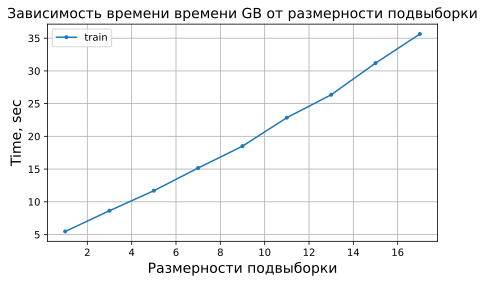

In [135]:
title = 'Зависимость времени времени GB от размерности подвыборки'
plot_time(time, feat_size, title, xlabel)
plt.savefig('gb_size_time.pdf')

Здесь всё абсолютно аналогично случайнному лесу. Однако, отметим, что график выходит гораздо быстрее на плато. Это можно объяснить алгоритмом градиентного бустинга, который исправляет ошибки предыдущих деревьев. Всюду далее будем выбирать 7 признаков для обучения каждого дерева.

Подберём последний параметр - $learning\_rate$, при фиксированных других.

In [19]:
def lrn_rate(regressor, X_train, y_train, X_val, y_val, n_trees, max_depth, feat_size, learning_rate):
    rmse_train = []
    rmse_val = []
    time = []
    
    for lr in learning_rate:
        start_time = timeit.default_timer()
        clf = regressor(n_estimators=n_trees, max_depth = max_depth,
                        feature_subsample_size = feat_size, learning_rate = lr)
        clf.fit(X_train, y_train)

        q_train = rmse(y_train, clf.predict(X_train))
        q_test = rmse(y_val, clf.predict(X_val))
        rmse_train.append(q_train)
        rmse_val.append(q_test)

        time.append(timeit.default_timer() - start_time)
    return rmse_train, rmse_val, time

In [137]:
learning_rate = np.logspace(-4, 0, 10)
rmse_train, rmse_test, time = lrn_rate(GradientBoostingMSE, X_tr, y_tr, X_val, y_val, 1000, 3, 7, learning_rate)

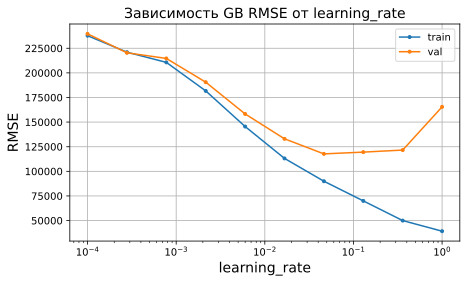

In [138]:
title = 'Зависимость GB RMSE от learning_rate'
xlabel = 'learning_rate'
plot_rmse(rmse_train, rmse_test, learning_rate, title, xlabel)
plt.xscale("log")
plt.savefig('gb_lr_rmse.pdf')

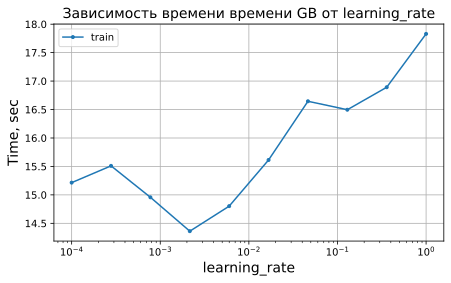

In [139]:
title = 'Зависимость времени времени GB от learning_rate'
plot_time(time, learning_rate, title, xlabel)
plt.xscale("log")
plt.savefig('gb_lr_time.pdf')

Заметим, то слишком маленький темп обучения приводит к очень большим значениям ошибки. Это можно объснить тем, что каждое последующее дерево исправляет ошибки предыдущих. Тем самым при очень маленьком $learning\_rate$ этот "вклад" новых деревьев почти не будет учитываться. Т.е. ошибки, произошедшие на прошлой итерации, прктически не будут исправляться... Однако при слишком большом значении этого параметра модель будет уделять большее внимание новым деревьям, которые заточены только на ошибки, но не на правильные ответы предыдущих. Следовательно, модель в меньшей степени будет учитывать "правильность" предыдущих методов. Таким образом, темп обучения должен быть не сильно маленьким, но и не большим. На графике видно, что оптимальное значение близко к дефолтному. Его мы и будем использовать.

Теперь обучим модель на всей выборке и посмотрим на качество работы алгоритма на тесте. Возьмём $n\_estimators=1000, max\_depth = 3, feature\_subsample\_size = 7, learning\_rate = default$.

In [35]:
%%time
clf = GradientBoostingMSE(n_estimators=1000, max_depth = 3,
                      feature_subsample_size = 7)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Wall time: 21.5 s


In [141]:
print(f'GradientBoosting RMSE: {rmse(y_test, y_pred)}')

GradientBoosting RMSE: 118715.79860248356


Качество существенно улучшилось, что говорит о том, что градиентный бустинг более подходящая модель в данно задаче.